In [1]:
from imp import reload
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import random
import datetime
from  tqdm import tqdm
import math

import data_generator
import hparams
reload(hparams)
import model_unet
reload(model_unet)
import numpy as np
import loss_function
reload(loss_function)
import utils
reload(utils)
import evaluate

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda:0 device


In [2]:
# 一个epoch的训练+测试
def train(dataloader, model, loss_fn, optimizer, scheduler, out_floor):
    model.train()
    size = len(dataloader.dataset)
    batch_num = math.ceil(size/dataloader.batch_size)
    loss_total = 0
    
    for batch, (X, y) in tqdm(enumerate(dataloader)): # 每次返回一个batch
        # X, y = X.cuda(device=device_ids[0]), y.cuda(device=device_ids[0])
        X, y = X.cuda(), y.cuda()
        # Compute prediction error
        pred = model(X, out_floor)
        
        if out_floor == 0:
            loss = loss_fn(pred, y)
        else:
            # downsample y
            y_downsample = utils.downsample(y, out_floor)
            # print(pred.shape, y_downsample.shape)
            loss = loss_fn(pred, y_downsample)
            
        # 对于某些特殊的损失函数：
        if args.loss in [2,3]:
            loss = (loss[0].sum()+loss[2].sum())/(loss[1].sum()+loss[3].sum())
        elif args.loss in [0,1]:
            loss = loss.sum()
            
        loss_total += loss.item()
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch+1) % 50 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Avg loss: {loss:.4f}  [{current:>5d}/{size:>5d}]")
            
    scheduler.step()
    return loss_total/batch_num

threshold = 0.05
args_loss = 3
def test(dataloader, model, loss_fn, out_floor):
    
    with torch.no_grad():
    
        size = len(dataloader.dataset)
        batch_num = math.ceil(size/dataloader.batch_size)

        model.eval()
        test_loss = 0
        test_loss_v, test_loss_nv = 0, 0
        test_loss_f, test_loss_t = 0, 0
        oa_avg, vr_avg, vfa_avg, rpa_avg, rca_avg = 0, 0, 0, 0, 0
    
    
        for X, y in dataloader:
            # X, y = X.cuda(device=device_ids[0]), y.cuda(device=device_ids[0])
            X, y = X.cuda(), y.cuda()
            Xpred = model(X, out_floor)
            Xout = utils.salience_to_output(Xpred.clone().detach(), threshold=threshold)
            
            if out_floor == 0:
                loss = loss_fn(Xpred, y)
                oa, vr, vfa, rpa, rca = evaluate.evaluate(Xout, y, out_floor)
            else:
                y_downsample = utils.downsample(y, out_floor)
                loss = loss_fn(Xpred, y_downsample)
                oa, vr, vfa, rpa, rca = evaluate.evaluate(Xout, y_downsample, out_floor)
                
            if args_loss == 2:
                loss_gather = (loss[0].sum()+loss[2].sum())/(loss[1].sum()+loss[3].sum())
                loss_v_gather = loss[0].sum()/loss[1].sum()
                loss_nv_gather = loss[2].sum()/loss[3].sum()
                test_loss_v += loss_v_gather.item()
                test_loss_nv += loss_nv_gather.item()
            elif args_loss == 3:
                loss_gather = (loss[0].sum()+loss[2].sum())/(loss[1].sum()+loss[3].sum())
                loss_f_gather = loss[0].sum()/loss[1].sum()
                loss_t_gather = loss[2].sum()/loss[3].sum()
                test_loss_f += loss_f_gather.item()
                test_loss_t += loss_t_gather.item()
            elif args_loss in [0,1]:
                loss_gather = loss.sum()
            
            test_loss += loss_gather.item()

            
            oa_avg += oa
            vr_avg += vr
            vfa_avg += vfa
            rpa_avg += rpa
            rca_avg += rca
            
    test_loss /= batch_num # 每张图的loss
    test_loss_v /= batch_num
    test_loss_nv /= batch_num
    test_loss_f /= batch_num
    test_loss_t /= batch_num
    
    oa_avg /= batch_num
    vr_avg /= batch_num
    vfa_avg /= batch_num
    rpa_avg /= batch_num
    rca_avg /= batch_num
    
    print(f"Test Error: Avg loss: {test_loss:.4f} \n")
    print(f"Test OA\t{oa_avg:.4f}\tVR\t{vr_avg:.4f}\tVFA\t{vfa_avg:.4f}\tRPA\t{rpa_avg:.4f}\tRCA\t{rca_avg:.4f}\n")
    
    if args_loss in [0,1,2]:
        return (test_loss, test_loss_v, test_loss_nv), oa_avg, vr_avg, vfa_avg, rpa_avg, rca_avg
    elif args_loss in [3]:
        return (test_loss, test_loss_f, test_loss_t), oa_avg, vr_avg, vfa_avg, rpa_avg, rca_avg

# split data, generate train/test_dataloader

In [3]:
# 划分数据
'''
fold_index = list(range(10))
random.shuffle(fold_index)
test_fold_index = fold_index[0]
validation_fold_index = fold_index[1]
train_fold_index_list = fold_index[2:]
'''
train_fold_index_list = hparams.train_set_fold_index
valid_fold_index_list = hparams.validation_set_fold_index
test_fold_index_list = hparams.test_set_fold_index

In [4]:
# prepare


print(f'{datetime.datetime.now()} - Preparing train_dataloader...')
train_dataloader = data_generator.source_index_to_chunk_list(source_list=train_fold_index_list,
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training)
train_dataloader = DataLoader(train_dataloader, batch_size=16, shuffle=True)


print(f'{datetime.datetime.now()} - Preparing valid_dataloader...')
valid_dataloader = data_generator.source_index_to_chunk_list(source_list=valid_fold_index_list,
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training)#[0:32]
valid_dataloader = DataLoader(valid_dataloader, batch_size=16, shuffle=True)

print(f'{datetime.datetime.now()} - Preparing test_dataloader...')
test_dataloader = data_generator.source_index_to_chunk_list(source_list=test_fold_index_list,
                                                             data_chunks_duration_in_bins=hparams.data_chunks_duration_in_bins,
                                                             data_chunks_overlap_in_bins=hparams.data_chunks_overlap_in_bins_for_training)#[0:32]
test_dataloader = DataLoader(test_dataloader, batch_size=16, shuffle=True)

2021-08-09 19:49:26.133574 - Preparing train_dataloader...
2021-08-09 19:49:33.163833 - Preparing valid_dataloader...
2021-08-09 19:49:33.487924 - Preparing test_dataloader...


In [6]:
# 测试模型在测试集上的效果
model = model_unet.UNet().cuda()
model = nn.DataParallel(model)

model.load_state_dict(torch.load('./model/F3/model_0.pth'))

# model = torch.load('./model/test/model_floor3_best.pth')

<All keys matched successfully>

In [9]:
# test set result?
loss_fn = loss_function.CrossEntropyLoss_for_FA_CE_TF().cuda()
loss_fn = nn.DataParallel(loss_fn)

test(valid_dataloader, model, loss_fn, 3)

/home/yangds/anaconda3/envs/csi/lib/python3.8/site-packages/torch/nn/parallel/_functions.py:64: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test Error: Avg loss: 2.9550 

Test OA	0.5948	VR	0.8428	VFA	0.3777	RPA	0.5817	RCA	0.5857



((2.955037292886953, 5.312765645199135, 1.353295274445268),
 0.5948384114367723,
 0.8427985768259655,
 0.37774261778876067,
 0.5817442501505662,
 0.5857276293405898)

In [10]:
# optimizer
'''
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)
scheduler_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94, verbose=True)
scheduler_stop = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', threshold=1e-4, factor=-1, patience=10)
'''


"\noptimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)\nscheduler_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.94, verbose=True)\nscheduler_stop = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', threshold=1e-4, factor=-1, patience=10)\n"

# 逐个比较损失

In [10]:
import evaluate
reload(evaluate)

out_floor = 3

model.eval()

pass

(0.7878787878787878, 0.9423076923076923, 0.21428571428571427, 0.7884615384615384, 0.7884615384615384)
------------


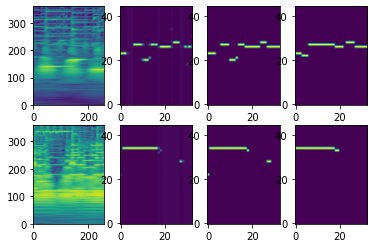

In [22]:
with torch.no_grad():
    for a, b in train_dataloader:
        X, y = a.cuda(), b.cuda()
        X = X[0:2]
        y = y[0:2]
        
        Xpred = model(X, out_floor)
        Xshow = utils.salience_to_output(Xpred.clone().detach(), threshold=0.05)
        y_downsample = utils.downsample(y, out_floor).int()
        # print(f'Xpred: {Xpred.shape}')
        # print(f'y_downsample: {y_downsample.shape}')
        loss = loss_fn(Xpred, y_downsample)
        loss = (loss[0]+loss[2])/(loss[1]+loss[3])
        # print(loss)
        
        print(evaluate.evaluate(Xshow, y_downsample, 3))
        
        plt.subplot(241)
        plt.imshow(X[0][0].cpu(), origin='lower')
        plt.subplot(242)
        plt.imshow(Xpred[0][0].cpu(), origin='lower')
        plt.subplot(243)
        plt.imshow(Xshow[0][0].cpu(), origin='lower')
        plt.subplot(244)
        plt.imshow(y_downsample[0].cpu(), origin='lower')
        
        plt.subplot(245)
        plt.imshow(X[1][0].cpu(), origin='lower')
        plt.subplot(246)
        plt.imshow(Xpred[1][0].cpu(), origin='lower')
        plt.subplot(247)
        plt.imshow(Xshow[1][0].cpu(), origin='lower')
        plt.subplot(248)
        plt.imshow(y_downsample[1].cpu(), origin='lower')
        
        print('------------')
        

        break

In [ ]:
plt.subplot(131)
plt.imshow(Xpred[0][0].cpu(), origin='lower')
plt.subplot(132)
plt.imshow(Xshow[0][0].cpu(), origin='lower')
plt.subplot(133)
plt.imshow(y_downsample[0].cpu(), origin='lower')

In [ ]:
loss_fn(Xpred, y_downsample)

In [ ]:
import loss_function.CrossEntropyLoss_Origin as loss

In [ ]:
for X, y in train_dataloader:

    y_downsample = utils.downsample(y, 3)
    
    break

plt.figure(figsize=(10,10))

plt.subplot(231)
plt.imshow(y[0], origin='lower')
plt.subplot(232)
plt.imshow(y_downsample[0], origin='lower')

plt.subplot(234)
plt.imshow(y[1], origin='lower')
plt.subplot(235)
plt.imshow(y_downsample[1], origin='lower')
plt.show()

In [ ]:
loss_fn = CrossEntropyLoss_Origin().to(device)

model.eval()
model2.eval()

X, y = None, None
for a,b in tqdm(train_dataloader):
    X, y = a.to(device), b.to(device)

    Xpred = model(X, 2)
    y_downsample = utils.downsample(y, 2)

    temp = Xpred[0,0].detach().to('cpu').numpy()

    clean = utils.salience_to_output(temp, threshold=0)


    Xpred2 = model2(X, 2)

    temp2 = Xpred2[0,0].detach().to('cpu').numpy()

    clean2 = utils.salience_to_output(temp2, threshold=0)
    
    if loss_fn(Xpred, y_downsample) + 10 < loss_fn(Xpred2, y_downsample):
    
        plt.subplot(231)
        plt.imshow(y_downsample[0].detach().to('cpu').numpy(), origin='lower')
        plt.subplot(232)
        plt.imshow(temp, origin='lower')
        plt.subplot(233)
        plt.imshow(clean, origin='lower')

        plt.subplot(234)
        plt.imshow(y_downsample[0].detach().to('cpu').numpy(), origin='lower')
        plt.subplot(235)
        plt.imshow(temp2, origin='lower')
        plt.subplot(236)
        plt.imshow(clean2, origin='lower')
        plt.show()
        print(loss_fn(Xpred, y_downsample) , loss_fn(Xpred2, y_downsample))

# 保存模型

In [ ]:
torch.save(model.state_dict(), 'model_12epoch.pth')

model = model_unet.UNet(device=device)
model.load_state_dict(torch.load('model_9epoch.pth'))

In [ ]:
try:
    !jupyter nbconvert --to python train_the_model.ipynb
except:
    pass